# Project Milestone P2 — StatSquad3 — How does the sentiment of Wikispeedia articles affect player game paths?
## I. Exploring sentiment annotation methods

- In this project, we aim to describe and analyze data based on a sentiment associated to each Wikispeedia page. To do so, we believe that our analyses will strongly depend on the sentiment annotation method. Therefore, in this first part, we extensively explore the different methods of sentiment annotation. 
- By "sentiment annotation", we mean that each article will be given a score for its content. A sentiment score $s\in[-1,1]$ where $s=1$ (respectively, $s=0$, $s=-1$) means an article is associated to a positive (respectively, neutral, negative) sentiment.
#### We start off by exploring different method for sentiment annotation of the Wikispeedia articles. Namely, we explore five different methods: 
1. Using sentiment lexicons to infer sentiment frequencies
2. pattern package (python)
3. [Vader](https://vadersentiment.readthedocs.io/en/latest/index.html)
4. [LIWC](https://www.liwc.app/dictionaries)
5. Large language model ([Roberta for sentiment analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment))

In order for us to compare these different methods, we manually put together a small validation set of articles that are considered very positive, very negative, or neutral. We show it below:

In [1]:
import pandas as pd

validation = pd.read_csv("../validation.txt", sep="\t", header=None, names=["article", "sentiment"])
validation = validation.set_index("article")
validation.head()

,sentiment
article,
1755_Lisbon_earthquake,-1
1896_Summer_Olympics,1
1997_Pacific_hurricane_season,-1
Actinium,0
Barracuda,-1


In the next sections, we try to reproduce the sign of the sentiment rather than the score it

### 1. Lexicons

#### Method: we use a sentiment lexicon: each word in the lexicon has a positive and negative score both in the interval $[0,1]$. For each article, we infer the sentiment score by computing $\text{positive-score}-\text{negative-score}$

In [2]:
from sentiment_analysis_1 import *

In [3]:
articles = load_titles()
print(len(articles), "articles found")

4604 articles found


In [4]:
content = load_html(articles)

Load and parse lexicons

In [5]:
sentiment_lexicon_path = "../sentiwordnet/SentiWordNet_3.0.0.txt"
df = pd.read_csv(sentiment_lexicon_path, sep="\t", skiprows=25, skipfooter=1, engine="python")

def parse_synset_terms(row):
    words = row.split()
    words = [word.split('#')[0] for word in words]
    return words

df['SynsetTerms'] = df['SynsetTerms'].apply(parse_synset_terms)
df = df.explode('SynsetTerms').reset_index(drop=True)
df[["PosScore", "NegScore", "SynsetTerms"]].head()

,PosScore,NegScore,SynsetTerms
0,0.125,0.00,able
1,0.000,0.75,unable
2,0.000,0.00,dorsal
3,0.000,0.00,abaxial
4,0.000,0.00,ventral


Compute sentiment score for lexicon

In [6]:
sentiment = dict(zip(df.SynsetTerms, round(df.PosScore - df.NegScore,5)))

Infer sentiment score for validation data

In [7]:
def model(articles_content, lexicon):
    """
    Infer the sentiment prediction for articles on their content, according to lexicon of sentiments
    Args:
        articles_content: dict(), dictionary of (article-title: article-content) pairs
        lexicon: dict(), dictionary of (word: sentiment) pairs, with sentiment a sentiment score
    Returns:
        dict(), dictionary of (article-title: average-score) pairs
    """
    article_scores = {}

    for title, content in articles_content.items():
        words = content.split()
        word_scores = [lexicon[word] for word in words if word in lexicon]
        average_score = sum(word_scores) / len(word_scores) if len(word_scores) > 0 else None
        article_scores[title] = average_score

    return article_scores

In [8]:
validation_content = dict(zip(list(validation.index), [None]*len(validation)))
for k in validation_content.keys():
    validation_content[k] = content[k]

In [9]:
scores = model(validation_content, sentiment)

In [10]:
validation["prediction"] = scores.values()

In [11]:
validation.head()

,sentiment,prediction
article,,
1755_Lisbon_earthquake,-1,-0.050156
1896_Summer_Olympics,1,-0.006281
1997_Pacific_hurricane_season,-1,-0.037893
Actinium,0,-0.005826
Barracuda,-1,-0.002747


In [12]:
print("Number of correct prediction signs:")
print(sum((validation["sentiment"] * validation["prediction"]) > 0), "/", len(validation))

Number of correct prediction signs:
15 / 35


We also tried correcting the predictions by a bias (by adding a weighted average of the predictions), but we cannot do better than that. The model is therefore worse than a random classifier.

### 2. Pattern

In [13]:
file_names = ['1755_Lisbon_earthquake','1896_Summer_Olympics','1997_Pacific_hurricane_season','Actinium','Barracuda','Basketball','Bath_School_disaster','Chicago','Chocolate','Diamond','Dice','Drinking_water','Duchenne_muscular_dystrophy','Geography_of_Ireland','Giraffe','Gunpowder','Osama_bin_Laden','Palm_oil','Peace','Pellagra','Phishing','Plant','Plato','Pneumonia','Poison_gas_in_World_War_I','Politics','Pollution','Red_Kite','Rice','Rio_de_Janeiro','Romeo_and_Juliet','Rugby_World_Cup','Rwandan_Genocide','Santa_Claus','Scooby-Doo']
len(file_names)

35

#### Model Description
Pattern is a multipurpose library that is capable of handling NLP operations, data mining, machine learning etc. It also contains sentiment analysis functionality which is suitable for our task.
The `sentiment` function under `pattern.text.en` module is used to calculate the sentiment of a given text, it takes a sentence as input which can also be a string, Synset, word or document, and returns a (polarity, subjectivity)-tuple with polarity between -1.0 and +1.0 and subjectivity between 0.0 and 1.0. polarity describes the emotional leaning of the text, while subjectivity describes the strength of such emotion.

In our usage the input is a string of the entire article loaded from the Wikispeedia dataset, In this case, it first tokenizes the text into words(punctuation, space and abbreviations are handled at this stage), then it Lowercases each word because sentiment analysis is case insensitive. Next it calculates the sentiment of each word by consulting the predefined sentiment [dictionary](https://github.com/clips/pattern/blob/master/pattern/text/en/en-sentiment.xml)(modifiers and negations are also considered at this time). Finally it returns the average of all the words as the sentiment of the text.

Although similar to the above method, pattern is certainly a more complete method and it includes the subjectivity measure which is especially in the case of Wikipedia, as the articles are, after all, written by humans. More details can be found in the [official documentation](https://digiasset.org/html/pattern.html) and [repository](https://digiasset.org/html/pattern.html). 

#### Method & Results

In [16]:
from pattern.text.en import sentiment

BadZipFile: File is not a zip file

In [15]:
for file_name in file_names:
    with open('../data/plaintext_articles/'+file_name+'.txt', 'r', encoding='utf-8') as file:
        data = file.read()
        polarity, subjectivity = sentiment(data)
        print(f"{file_name}: {polarity}")

BadZipFile: File is not a zip file

#### Discussion
The performance of this model is generally not good compared to other models we tested, the possible reason could be that it uses a fixed sentiment dictionary which may contain bias between different domains. It's observed that the model tends to give a very small value between [0,0.1] despite the articles, a reason could be that Wikipedia articles are designed to be neutral and objective, It generally looks at problems dialectically and rarely produces strong emotions. However, in the range of this project, we care more about the sentiment level of the article (the word itself) rather than the way it is written, the model considers all the words on the page evenly and thus may produce results that are not what we expect.

This is not the optimal model for our task, a ML-based approach is generally more flexible and powerful in this case.

### 3. Vader

#### Model description
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis method attuned expressions from social media. This model classies the text into positive, neutral, and negative parts, then by leveraging lexicon and grammatical rules, from valence scores compute the 'compound score' which is normalized weighted composite score of the sentiment of the text.

Utilizing NLTK, VADER takes into condsideration the text nuances, informal phrases, and even non-English text sentences.

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm
from sentiment_analysis_3 import *

#### Load articles' titles and content

In [18]:
articles = load_titles_3()
content = load_html_3(articles)

#### Analysing the compound score

In [19]:
scores = []
analyzer = SentimentIntensityAnalyzer()
for article_content in tqdm(content.iloc):
    vs = analyzer.polarity_scores(article_content.content)
    scores.append(vs['compound'])

0it [00:00, ?it/s]

#### Resulted scores

In [20]:
content['score'] = scores
content.drop(columns='content')

,title,score
0,1755_Lisbon_earthquake,-0.9970
1,1896_Summer_Olympics,0.9999
2,1997_Pacific_hurricane_season,-0.9998
3,Actinium,-0.8792
4,Barracuda,0.9944
5,Basketball,0.9999
6,Bath_School_disaster,-0.9998
7,Chicago,0.9999
8,Chocolate,0.9996
9,Diamond,1.0000


#### Discussion 
As can be inferred from the prediction, the model is good at correctly splitting the articles into two separate clusters, with a quite impressive squared error of 0.2. However, the obtained scores are quite extreme, making it impractical to infer the intensity of the negative or positive sense of each article. This could be attributed to the prevalence of neutral words, causing smaller differences between negative and positive counterparts.

### 4. LIWC
#### Model Description

Linguistic Inquiry and Word Count (LIWC) is a sentiment analysis model based on over 100 dictionaries. In each of these dictionaries, words are assiociated with psychological state, as positive, negative, but also moralization and cognitive process for example. LIWC analyzes each word and compare it with the dictionnaries, to output the percentage of word that belong to each category. In our case, only the 'positive tone' and 'negative tone' category are of interest.

#### Method & Results

The free LIWC demo version has a 5000 character limit, so the first step is to divide the text in several chunks that can be run through the demo.

Note: for clarity we leave the main pipelines in the notebook ```sentiment_analysis_4.ipynb```. Here we load the predictions directly.

In [36]:
preds = pd.read_csv('./tmp/finalscore.csv',header=None)

In [41]:
preds

,0
0,-0.324
1,0.792
2,-0.703
3,-0.856
4,0.223
5,0.356
6,-0.538
7,0.682
8,0.263
9,0.638


#### Comparison

The results are then compared to the expected results (manually evaluated). Both can be plotted on a graph to have a visualization of the accuracy of the model. The mean square error is then calculated.

The mean square error of the model on the validation articles is 0.381691


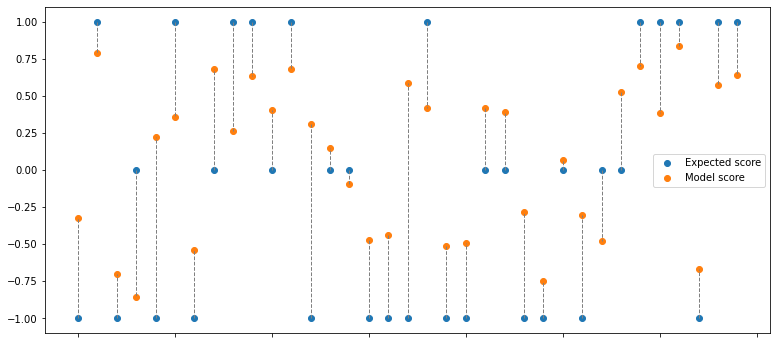

In [40]:
import matplotlib.pyplot as plt
import numpy as np

expected_score=np.array([-1,1,-1,0,-1,1,-1,0,1,1,0,1,-1,0,0,-1,-1,-1,1,-1,-1,0,0,-1,-1,0,-1,0,0,1,1,1,-1,1,1])
model_score=np.array(preds).reshape(-1)

errors=expected_score-model_score

x=np.arange(len(expected_score))

fig,ax=plt.subplots(1,figsize=(13,6))

ax.scatter(x,expected_score,label='Expected score')
ax.scatter(x,model_score,label='Model score')

for i in range(len(x)):
    ax.plot([x[i],x[i]],[expected_score[i],model_score[i]],color='gray',linestyle='--',linewidth=1)

ax.set_xticklabels([])
ax.legend()

mse=np.mean(np.square(errors))

print(f'The mean square error of the model on the validation articles is {mse}')

In conclusion: this model is already much better than the previous ones.

### 5. Roberta for sentiment analysis

For practical purposes, we do not run Roberta in this notebook. We have done it in a machine with sufficient memory to infer the predictions on the validation data, which we load and show below. The notebook used is ```sentiment_analysis_5.ipynb```.

In [42]:
preds = np.array([-0.75, 0.62, -0.71, -0.85, 0.42, 0.56, -0.81, 0.65, 0.42, 0.58, 0.57, 0.21, -0.62, -0.44, 0.36, -0.64, -0.8, 0.58, 0.53, -0.86, -1, 0.43, 0.43, -0.93, -0.94, 0.39, -0.82, -0.55, 0.49, 0.86, -0.53, 0.65, -0.96, 0.61, 0.58])

The mean square error of the model on the validation articles is 0.35532857142857144


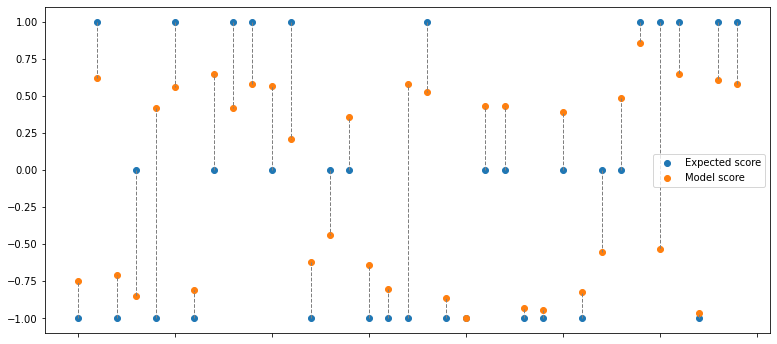

In [43]:
expected_score=np.array([-1,1,-1,0,-1,1,-1,0,1,1,0,1,-1,0,0,-1,-1,-1,1,-1,-1,0,0,-1,-1,0,-1,0,0,1,1,1,-1,1,1])
model_score=preds

errors=expected_score-model_score

x=np.arange(len(expected_score))

fig,ax=plt.subplots(1,figsize=(13,6))

ax.scatter(x,expected_score,label='Expected score')
ax.scatter(x,model_score,label='Model score')

for i in range(len(x)):
    ax.plot([x[i],x[i]],[expected_score[i],model_score[i]],color='gray',linestyle='--',linewidth=1)

ax.set_xticklabels([])
ax.legend()

mse=np.mean(np.square(errors))

print(f'The mean square error of the model on the validation articles is {mse}')

Visually, Roberta seems to be similar to the previous LIWC model. Indeed, the bars larger than 1 (the ones that "invert" the sentiment of the article) are equally present in this plot compared to the previous one. However, the MSE is slightly lower, so we should perhaps use this model as the inference for the sentiment.

# II. Some initial analyses and initial loading pipelines for player paths